<a href="https://colab.research.google.com/github/alexdefrutos/ML.portfolio/blob/master/OW/OW_AdeFrutos_DataChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oliver Wyman - Data Science Challenge

The following Notebook has been divided en in the following sections:


0.   Introduction about the topic and the dataset
1.   Baseline and conclusion
2.   FEA & Final Model
3.   Conclusions
4.   Annex



## 0.- Introduction about the topic.

In [0]:
'''
According to Infosecurity Magazine, fraud cost the global economy £3.2 trillion in 2018 and for
some businesses, losses to fraud reach more than 10% of their total spending.

https://www.infosecurity-magazine.com/news/global-fraud-hits-32-trillion/

Capgemini claims their ML fraud detection system can reduce fraud investigation time by 70% while increasing accuracy by 90%. 
Another ML fraud prevention solution provider, Feedzai, claims that a well-trained machine learning solution can identify and prevent 95% of all
fraud while minimizing the amount of human labor required during the investigation stage.
https://www.capgemini.com/in-en/wp-content/uploads/sites/6/2017/07/next-generation_fraud_management_solutions_for_banks_and_capital_market_firms.pdf
https://feedzai.com/wp-content/uploads/2017/03/DML-Final.pdf

Fraud detection algorithms are already in a lot of industries as: Fintech, e-commerce, banking, healthcare, online gaming, and other industries.

'''

In [0]:
# About the dataset
'''
The data is broken into two files identity and transaction, which are joined by TransactionID. 

Not all transactions have corresponding identity information.

Categorical Features - Transaction file:

* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9
* (The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp)).

Categorical Features - Identity file:

* DeviceType
* DeviceInfo
* id_12 - id_38


'''

## Setting, imports and helpers

In [0]:
# Libraries
from scipy import stats
from zipfile import ZipFile 
import random
from IPython.display import display
from tqdm import tqdm_notebook

# Machine learning


from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import preprocessing


# Deep Learning

#from fastai.tabular import *
#from fastai.imports import *
#from fastai.callbacks import SaveModelCallback,CSVLogger


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Manipulation / FEA
from pathlib import Path
import pandas as pd
import numpy as np

from pandas.api.types import is_string_dtype, is_numeric_dtype


import datetime
import re

In [2]:
# To connect to Gdrive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# Path to the folder in Gdrive

path_to_drive=Path('/gdrive/My Drive/Colab Notebooks/OW')

In [0]:
# Helper Fuctions

In [0]:
def list_of_columns(fld, start, end):
  '''
  Return a list given a string and range on integrers:

  list_of_columns('M',1,3)
  returns
  ['M1','M2','M3']
  '''
  return [fld + str(i) for i in range(start, end+1)]

In [0]:
def add_datepart(df, fldname, drop=True):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
      next()
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Hour', 'Minute', 'Second', 'Dayofweek']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
def resumetable(df):
  " Produce an summary given a dataframe"
  print(f"Dataset Shape: {df.shape}")
  summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
  summary = summary.reset_index()
  summary['Name'] = summary['index']
  summary = summary[['Name','dtypes']]
  summary['Missing'] = df.isnull().sum().values
  summary['Missing_norm'] = df.isnull().sum().values/df.shape[0]
  summary['Uniques'] = df.nunique().values
  summary['First Value'] = df.loc[0].values
  summary['Second Value'] = df.loc[1].values
  summary['Third Value'] = df.loc[2].values

  for name in summary['Name'].value_counts().index:
      summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

  return summary

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    
    "It is a simple left Merge. It simply appends “_y” to duplicated columns on the right table."
    if right_on is None: right_on = left_on
    return left.merge(right, how='left',left_on=left_on, right_on=right_on,
                     suffixes=("", suffix))   

### General

In [0]:
# Categorical Features

cat_features=(['ProductCD'] + list_of_columns('card',1,6) + list_of_columns('addr',1,2) +list_of_columns('M',1,9) +['P_emaildomain','R_emaildomain']

              +list_of_columns('id_',12,38)+['DeviceType', 'DeviceInfo']

             )

# Numerical Features

cont_variable=[]

# Target featires

target='isFraud'

In [0]:
dtype = {categoty: str for categoty in cat_features}

### Loading files and reduce memory size


In [13]:
# Loading the Identify file

train_id_df=pd.read_csv(path_to_drive/'train_identity.csv', low_memory=True,dtype=dtype);
reduce_mem_usage(train_id_df);
train_id_df.head()

Mem. usage decreased to 35.76 Mb (20.7% reduction)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [30]:
resumetable(train_id_df)

Dataset Shape: (144233, 41)


,Name,dtypes,Missing,Missing_norm,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,0.000000,144233,2987004,2987008,2987010,17.14
1,id_01,float16,0,0.000000,77,0,-5,-5,2.27
2,id_02,float32,3361,0.023303,115655,70787,98945,191631,16.72
3,id_03,float16,77909,0.540161,24,NaN,NaN,0,0.32
4,id_04,float16,77909,0.540161,15,NaN,NaN,0,0.10
5,id_05,float16,7368,0.051084,93,NaN,0,0,2.40
6,id_06,float16,7368,0.051084,101,NaN,-5,0,2.63
7,id_07,float16,139078,0.964259,84,NaN,NaN,NaN,5.39
8,id_08,float16,139078,0.964259,94,NaN,NaN,NaN,5.72
9,id_09,float16,69307,0.480521,46,NaN,NaN,0,0.51


In [31]:
train_tr_df=pd.read_csv(path_to_drive/'train_transaction.csv', low_memory=True,dtype=dtype);
reduce_mem_usage(train_tr_df);
train_tr_df.head()


Mem. usage decreased to 562.62 Mb (68.3% reduction)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
resumetable(train_tr_df)

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Missing_norm,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,0.00000,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,0.00000,2,0,0,0,0.22
2,TransactionDT,int32,0,0.00000,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,0.00000,8195,68.5,29,59,8.10
4,ProductCD,object,0,0.00000,5,W,W,W,1.28
...,...,...,...,...,...,...,...,...,...
389,V335,float16,508189,0.86055,669,NaN,NaN,NaN,1.27
390,V336,float16,508189,0.86055,355,NaN,NaN,NaN,0.93
391,V337,float32,508189,0.86055,254,NaN,NaN,NaN,1.03
392,V338,float32,508189,0.86055,380,NaN,NaN,NaN,1.19


In [33]:
train_id_df.shape,train_tr_df.shape

((144233, 41), (590540, 394))

In [0]:
train_df=join_df(train_tr_df,train_id_df, "TransactionID")

In [34]:
train_id_df.shape,train_tr_df.shape,train_df.shape

((144233, 41), (590540, 394), (590540, 434))

In [0]:
del train_id_df,train_tr_df

In [0]:
train_df.to_pickle(path_to_drive/('data/train_df.pkl'))


##1.- Baseline Model

In [0]:
# Data
'''

'''
# Model
'''
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.
It implements machine learning algorithms under the Gradient Boosting framework.
XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way

XGBoostworks very well for structured data.
'''
# Metrics
'''
I  have chosen ROC as my performance metric due to characteristics of the problem ( Fraud detection ) the heavy class imbalance of this data set. 
About the ROC:
  a) ROC is a plot of signal (True Positive Rate) against noise (False Positive Rate). 
  b) The model performance is determined by looking at the area under the ROC curve (or AUC).

  It is important considering the trade-off between precision and recall and deciding accordingly which of them to prioritize when possible, 
  considering possible business outcomes.
'''
# Train - Validation Strategy

'''

I have decided to use K-fold which is a the best trade-off between training with the latest data / validate with the latest data.

K-fold ramdomly split the dataset into train / validation (80-20) n number of times.

I have trained n models with this different dataset which will give me a complete view of the problem
and calculating the average of each prediction should give me a better result.

'''

In [0]:
train_df=pd.read_pickle(path_to_drive/('data/train_df.pkl'))

In [0]:
train_df=train_df.drop('TransactionID',axis=1)

In [242]:
train_df.isFraud.value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

In [243]:
train_df.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [0]:
# for very imbalanced dataset, it is recommened to do sqrt()

xx = (train_df[target]==0).sum() / (train_df[target]==1).sum()
xx=np.sqrt(xx)

In [245]:
xx

5.251627052720545

In [246]:
'''
LabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
It can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels:
'''

'\nLabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1.\nIt can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels:\n'

In [0]:
y_train=train_df['isFraud'].copy()
X_train=train_df.copy()
X_train=X_train.drop('isFraud',axis=1)

#del train_df

lbl = preprocessing.LabelEncoder()

for col in cat_features:
    lbl.fit(list(X_train[col].values))
    X_train[col] = lbl.transform(list(X_train[col].values))


### Train

In [0]:
# K fold Train - Validation Strategy
epochs = 5
kf = KFold(n_splits = epochs, shuffle = True)

In [250]:

y_vl_list=list()
y_pred_val_list=list()
models_cv=list()
for train_idx, valid_idx in kf.split(X_train, y_train):
   
    m = xgb.XGBClassifier(
        n_estimators=1500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.8,
        tree_method='gpu_hist',
        scale_pos_weight=xx
    )
    
    X_tr, X_vl = X_train.iloc[train_idx, :], X_train.iloc[valid_idx, :]
    y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    m.fit(X_tr, y_tr)
    y_pred_train = m.predict_proba(X_tr)[:,1]
    y_pred_valid = m.predict_proba(X_vl)[:,1]

    y_vl_list.append(y_vl)
    y_pred_val_list.append(y_pred_valid)


    tr_error=roc_auc_score(y_tr, y_pred_train)
    vl_error=roc_auc_score(y_vl, y_pred_valid)
    models_cv.append(m)
    print('ROC AUC in train set  {:.3f}% and  valid set {:.3f}%'.format(tr_error,vl_error))
    

ROC AUC in train set  1.000% and  valid set 0.973%
ROC AUC in train set  1.000% and  valid set 0.972%
ROC AUC in train set  1.000% and  valid set 0.975%
ROC AUC in train set  1.000% and  valid set 0.974%
ROC AUC in train set  1.000% and  valid set 0.974%


###Evaluate performance

In [0]:
labels=list_of_columns('model',1,5)

In [0]:

def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots(figsize=(20,10))
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

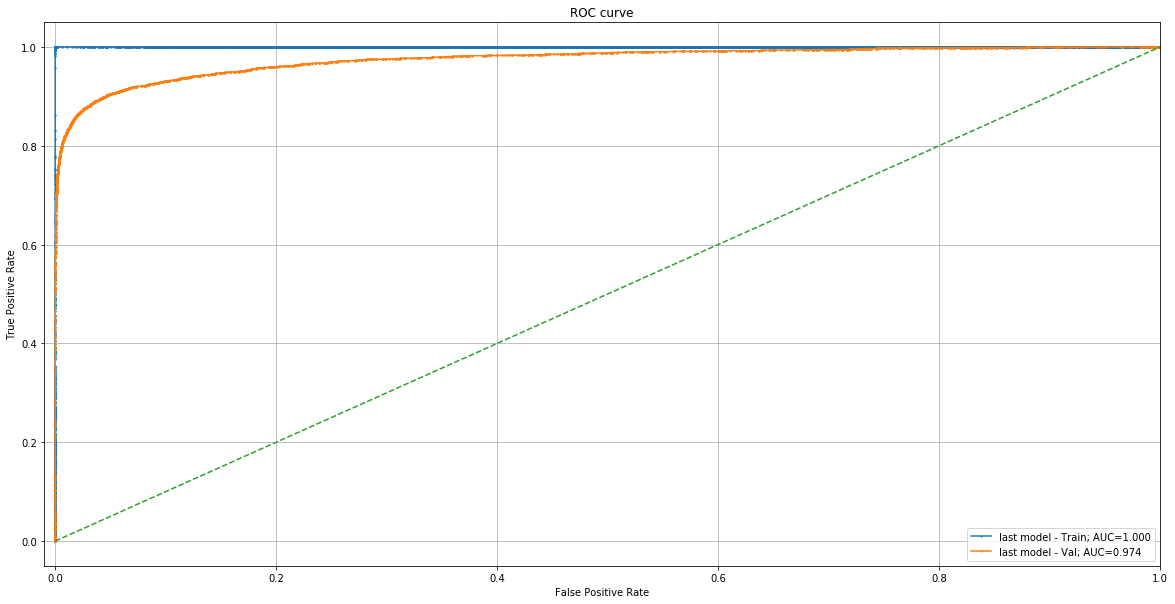

In [253]:
# See Train and valid performance

plot_roc(
    [y_tr, y_vl],
    [y_pred_train,y_pred_valid],
    ['last model - Train', 'last model - Val'])


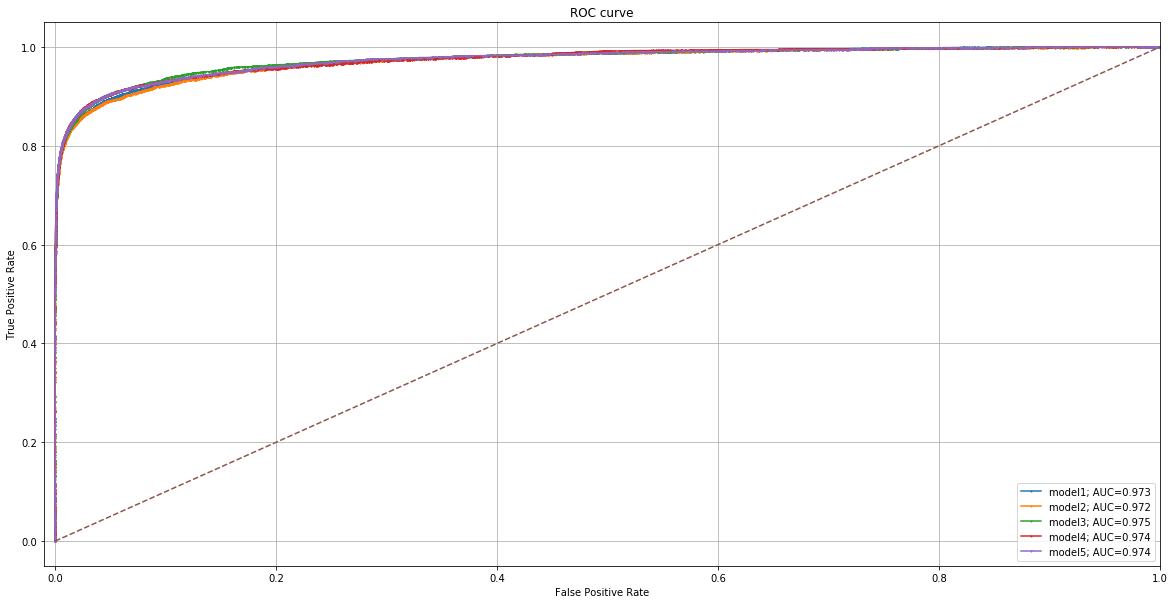

In [254]:
plot_roc(
    y_vl_list,
    y_pred_val_list,
    labels,
)


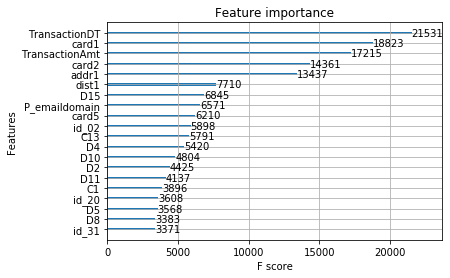

In [255]:
xgb.plot_importance(m,max_num_features=20,height=0.2)

In [0]:
test_preds = list()
for m in models_cv:
    test_preds.append(m.predict_proba(test_data)[:,1])
test_preds = np(test_preds).mean(axis=0)

## FEA - Categorical variables

In [0]:

#Using he importance plot, I have decided to further investigate the following variables:

# FEA Summary of FEa for Cat. Variables

'''
ProdctCD - N/A
card1-6: Reduction dimensionality
addr1-addr2 - Reduction dimensionality
M1-M9: N/A
P_emaildomain: Data Extraction and Reduction dimensionality
R_emaildomain: Data Extraction and Reduction dimensionality

DeviceType: NA
DeviceInfo:Data Extraction and Reduction dimensionality
['id_30','id_31','id_33] Data Extraction and Reduction dimensionality

Transaction DT: Extract time information.
'''

In [0]:
train_df=pd.read_pickle(path_to_drive/('data/train_df.pkl'))


In [0]:

cat_features=(['ProductCD'] + list_of_columns('card',1,6) + list_of_columns('addr',1,2) +list_of_columns('M',1,9) +['P_emaildomain','R_emaildomain']

              +list_of_columns('id_',12,38)+['DeviceType', 'DeviceInfo']

             )

In [0]:
def create_other(df,fld,min_value=300): 
  '''

  '''
  df.loc[df[fld].isin(df[fld].value_counts()[df[fld].value_counts() < min_value].index), fld] = "other"

In [0]:
train_df['n_nulls'] = train_df.isnull().sum(axis=1)
cont_variable += ['n_nulls']

In [0]:
def to_drop (fld,df=train_df,lista=cat_features):
  df.drop(fld,axis=1,inplace=True)
  lista.remove(fld)


In [0]:
# Data Extraction:

In [0]:

xx=train_df['P_emaildomain'].str.split('.',expand=True);
xx.fillna("NaN", inplace=True)
train_df['P_emaildomain_1']=xx[0]
train_df['P_emaildomain_2']=xx[1]

cat_features+=['P_emaildomain_1','P_emaildomain_2']
to_drop('P_emaildomain')

In [0]:
xx=train_df['R_emaildomain'].str.split('.',expand=True);
xx.fillna("NaN", inplace=True)
train_df['R_emaildomain_1']=xx[0]
train_df['R_emaildomain_2']=xx[1]
cat_features+=['R_emaildomain_1','R_emaildomain_2']
to_drop('R_emaildomain')

In [0]:
# I didn't consider the info about the version. As it may not be applicable for the future data.
xx=train_df['id_30'].str.rsplit(n=1,expand=True);
xx.fillna("NaN", inplace=True)
train_df['OS']=xx[0]

cat_features+=['OS']
to_drop('id_30')

In [0]:

# I didn't consider the info about the version. As it may not be applicable for the future data.

xx=train_df['id_31'].str.rsplit(n=1,expand=True);
xx.fillna("NaN", inplace=True)
xx.loc[xx[0].str.contains('chrome', na=False), 0] = 'Chrome'
xx.loc[xx[0].str.contains('firefox', na=False), 0] = 'Firefox'
xx.loc[xx[0].str.contains('safari', na=False), 0] = 'Safari'
xx.loc[xx[0].str.contains('edge', na=False), 0] = 'Edge'
xx.loc[xx[0].str.contains('ie', na=False), 0] = 'IE'
xx.loc[xx[0].str.contains('samsung', na=False), 0] = 'Samsung'
xx.loc[xx[0].str.contains('opera', na=False), 0] = 'Opera'

train_df['Browser']=xx[0]
cat_features+=['Browser']
to_drop('id_31')

In [0]:
# Higher resolution are linked to modern devices

xx=train_df['id_33'].str.split("x",n=2,expand=True);
xx.fillna(0, inplace=True)
zipper = zip(xx[0].astype(int), xx[1].astype(int))
xx['ratio']=[round((x/y),2) if x>0 else 0 for x,y in zipper]
train_df['Width']=xx[0];
train_df['ratio']=xx['ratio'];

cat_features+=['Width','ratio']
to_drop('id_33')

In [268]:
train_df.shape

(590540, 438)

In [269]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,n_nulls,P_emaildomain_1,P_emaildomain_2,R_emaildomain_1,R_emaildomain_2,OS,Browser,Width,ratio
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234,NaN,NaN,NaN,NaN,NaN,NaN,0,0.00
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230,gmail,com,NaN,NaN,NaN,NaN,0,0.00
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211,outlook,com,NaN,NaN,NaN,NaN,0,0.00
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227,yahoo,com,NaN,NaN,NaN,NaN,0,0.00
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,32.0,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,137,gmail,com,NaN,NaN,Android,Samsung,2220,2.06


In [0]:
# reduction dimensionality

for features in cat_features:
  try:create_other(train_df,features)
  except:print(features)

In [0]:
train_df.to_pickle(path_to_drive/('data/train_df_FEA.pkl'))

In [0]:
train_df=pd.read_pickle(path_to_drive/('data/train_df_FEA.pkl'))


In [0]:
# Transaction DT


xx['Delta']=train_df.TransactionDT.values-train_df.TransactionDT.min()
Starting_Date = '2018-1-1'
startdate = datetime.datetime.strptime(Starting_Date, "%Y-%m-%d")
train_df["Date"] = xx['Delta'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

add_datepart(train_df,"Date",drop=True)
train_df.drop(columns=['TransactionDT'],axis=1,inplace=True)

cat_features+= ['Hour', 'Minute', 'Second', 'Dayofweek']

In [0]:
train_df.drop(columns=['TransactionID'],axis=1,inplace=True)

In [181]:
resumetable(train_df)

Dataset Shape: (590540, 440)


,Name,dtypes,Missing,Missing_norm,Uniques,First Value,Second Value,Third Value,Entropy
0,isFraud,int8,0,0.000000,2,0,0,0,0.22
1,TransactionAmt,float16,0,0.000000,8195,68.5,29,59,8.10
2,ProductCD,object,0,0.000000,5,W,W,W,1.28
3,card1,object,0,0.000000,308,other,2755,4663,5.88
4,card2,object,8933,0.015127,166,NaN,404.0,490.0,5.69
...,...,...,...,...,...,...,...,...,...
435,ratio,object,0,0.000000,11,0,0,0,0.76
436,Hour,int64,0,0.000000,24,0,0,0,4.26
437,Minute,int64,0,0.000000,60,0,0,1,5.91
438,Second,int64,0,0.000000,60,0,1,9,5.91


In [182]:
train_df.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,...,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,n_nulls,P_emaildomain_1,P_emaildomain_2,R_emaildomain_1,R_emaildomain_2,OS,Browser,Width,ratio,Hour,Minute,Second,Dayofweek
0,0,68.5,W,other,NaN,150.0,discover,other,credit,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230,gmail,com,NaN,NaN,NaN,NaN,0,0,0,0,1,0
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211,outlook,com,NaN,NaN,NaN,NaN,0,0,0,1,9,0
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227,yahoo,com,NaN,NaN,NaN,NaN,0,0,0,1,39,0
4,0,50.0,H,other,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,32.0,match_status:2,T,F,T,T,mobile,other,137,gmail,com,NaN,NaN,Android,Samsung,2220,2.06,0,1,46,0


In [0]:
train_df.to_pickle(path_to_drive/('data/train_df_FEA_final.pkl'))

In [0]:
train_df=pd.read_pickle(path_to_drive/('data/train_df_FEA_final.pkl'))


### Train

In [101]:
'''
LabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
It can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels:
'''

'\nLabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1.\nIt can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels:\n'

In [0]:
y_train=train_df['isFraud'].copy()
X_train=train_df.copy()
X_train=X_train.drop('isFraud',axis=1)

#del train_df

lbl = preprocessing.LabelEncoder()

for col in cat_features:
    lbl.fit(list(X_train[col].values))
    X_train[col] = lbl.transform(list(X_train[col].values))


In [274]:
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,n_nulls,P_emaildomain_1,P_emaildomain_2,R_emaildomain_1,R_emaildomain_2,OS,Browser,Width,ratio,Hour,Minute,Second,Dayofweek
0,68.5,4,307,165,8,1,28,0,31,1,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,...,NaN,2,19,6,3,2,5,5,41,55,1,2,3,2,2,7,1,2,2,2,3,2,2,2,2,2,11,234,0,0,0,0,4,4,0,0,0,0,0,0
1,29.0,4,184,91,8,2,1,0,33,1,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,2,19,6,3,2,5,5,41,55,1,2,3,2,2,7,1,2,2,2,3,2,2,2,2,2,11,230,10,1,0,0,4,4,0,0,0,0,1,0
2,59.0,4,216,123,8,4,13,1,35,1,287.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,...,NaN,2,19,6,3,2,5,5,41,55,1,2,3,2,2,7,1,2,2,2,3,2,2,2,2,2,11,211,22,1,0,0,4,4,0,0,0,1,9,0
3,50.0,4,154,154,8,2,2,1,50,1,NaN,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,...,NaN,2,19,6,3,2,5,5,41,55,1,2,3,2,2,7,1,2,2,2,3,2,2,2,2,2,11,227,28,1,0,0,4,4,0,0,0,1,39,0
4,50.0,1,307,132,8,2,1,0,40,1,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,1,19,3,1,1,3,5,33,5,1,2,3,2,2,7,1,1,1,1,2,1,0,1,1,1,12,137,10,1,0,0,0,7,13,8,0,1,46,0


In [0]:
xx = (train_df[target]==0).sum() / (train_df[target]==1).sum()
xx=np.sqrt(xx)

In [0]:
# K fold Train - Validation Strategy
epochs = 5
kf = KFold(n_splits = epochs, shuffle = True)

In [277]:

y_vl_list=list()
y_pred_val_list=list()
models_cv=list()
for train_idx, valid_idx in kf.split(X_train, y_train):
   
    m = xgb.XGBClassifier(
        n_estimators=1500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.8,
        tree_method='gpu_hist',
        scale_pos_weight=xx
    )
    
    X_tr, X_vl = X_train.iloc[train_idx, :], X_train.iloc[valid_idx, :]
    y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    m.fit(X_tr, y_tr)
    y_pred_train = m.predict_proba(X_tr)[:,1]
    y_pred_valid = m.predict_proba(X_vl)[:,1]

    y_vl_list.append(y_vl)
    y_pred_val_list.append(y_pred_valid)


    tr_error=roc_auc_score(y_tr, y_pred_train)
    vl_error=roc_auc_score(y_vl, y_pred_valid)
    models_cv.append(m)
    print('ROC AUC in train set  {:.3f}% and  valid set {:.3f}%'.format(tr_error,vl_error))
    

ROC AUC in train set  1.000% and  valid set 0.965%
ROC AUC in train set  1.000% and  valid set 0.967%
ROC AUC in train set  1.000% and  valid set 0.964%
ROC AUC in train set  1.000% and  valid set 0.969%
ROC AUC in train set  1.000% and  valid set 0.968%


###Evaluate performance

In [0]:
labels=list_of_columns('model',1,5)

In [0]:

def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots(figsize=(20,10))
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

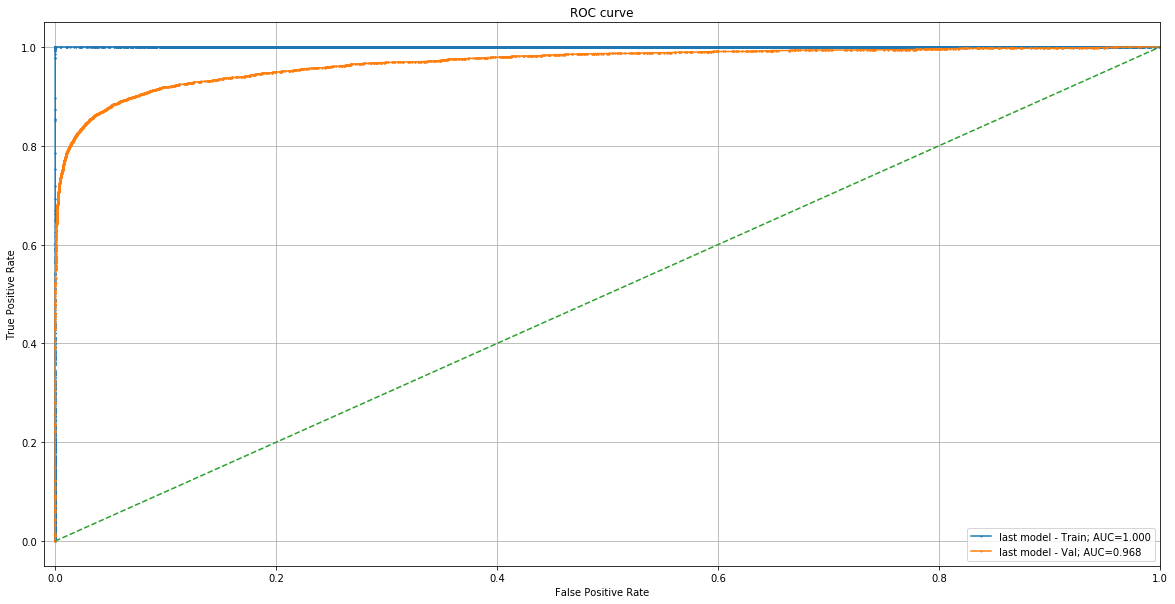

In [280]:
# See Train and valid performance

plot_roc(
    [y_tr, y_vl],
    [y_pred_train,y_pred_valid],
    ['last model - Train', 'last model - Val'])


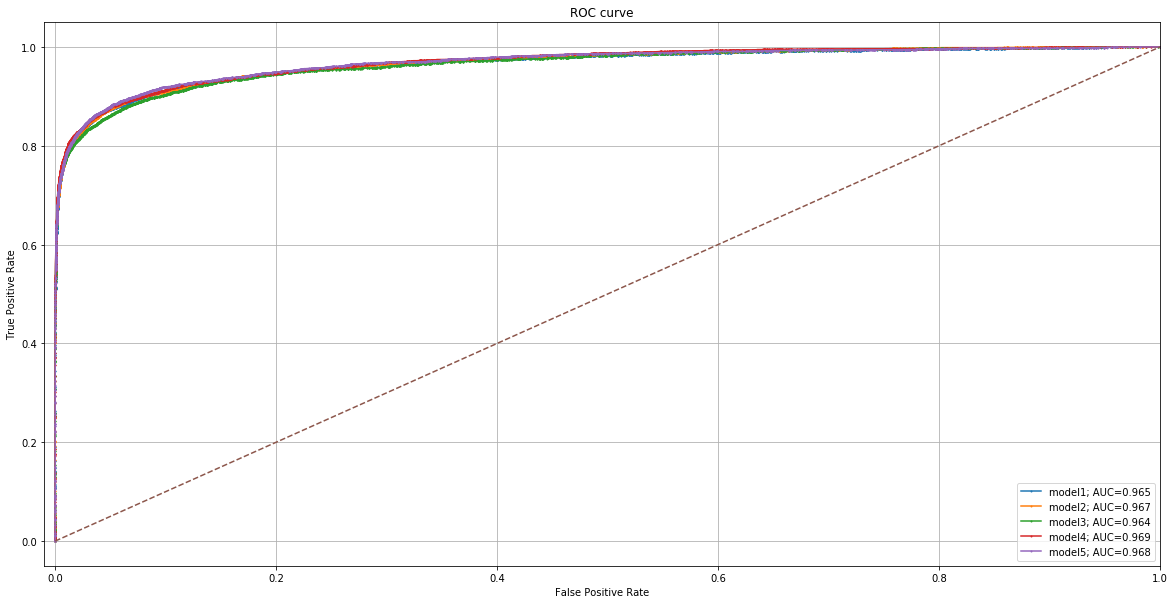

In [281]:
plot_roc(
    y_vl_list,
    y_pred_val_list,
    labels,
)


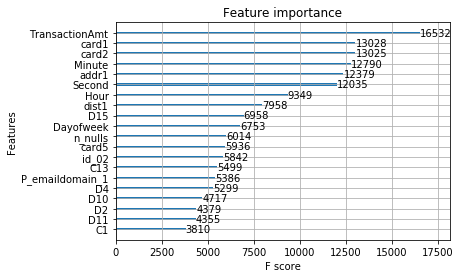

In [282]:
xgb.plot_importance(m,max_num_features=20,height=0.2)

In [0]:
test_preds = list()
for m in models_cv:
    test_preds.append(m.predict_proba(test_data)[:,1])
test_preds = np(test_preds).mean(axis=0)

## FEA - Numerical variables

In [0]:
'''
Transaction Amount is the top important feature.
In the following lines I have tried to extract more info:
a) Removing outlliers
b) calculating the log 
'''

In [0]:
train_df=pd.read_pickle(path_to_drive/('data/train_df_FEA_final.pkl'))

Text(0, 0.5, 'Probability')

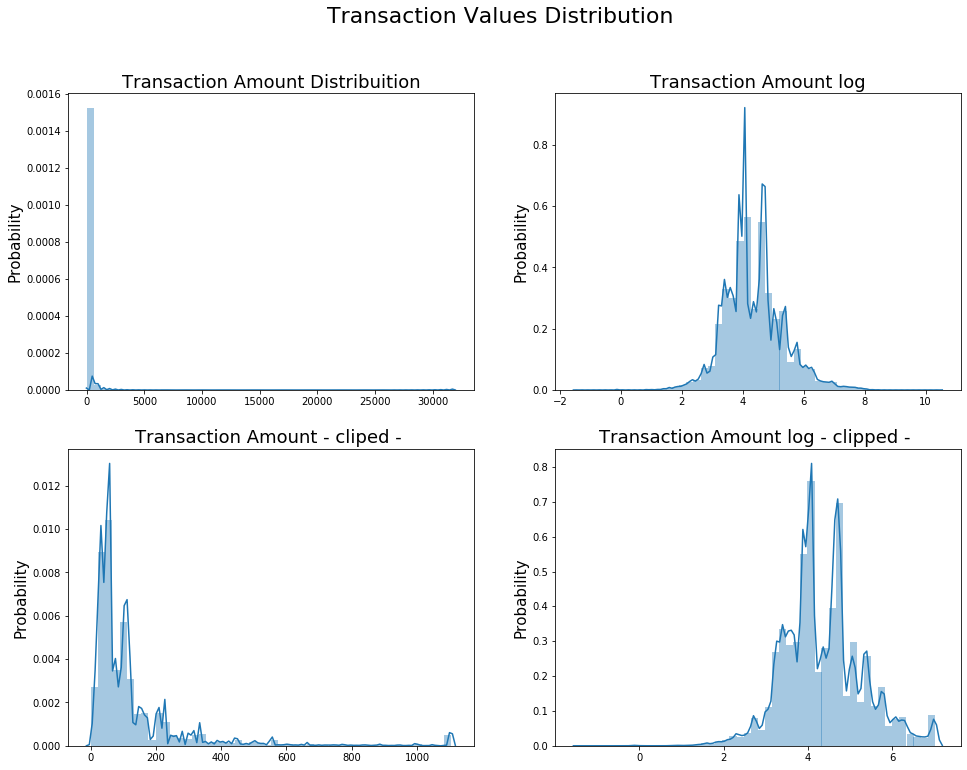

In [283]:
plt.figure(figsize=(16,12))

plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)

g = sns.distplot(train_df['TransactionAmt'])
g.set_title("Transaction Amount Distribuition", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)


plt.subplot(222)


g = sns.distplot(np.log(train_df['TransactionAmt']))
g.set_title("Transaction Amount log", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

xx=train_df.copy()
xx['TransactionAmt'] = xx['TransactionAmt'].clip(upper = xx['TransactionAmt'].quantile(.99))


plt.subplot(223)


g = sns.distplot((xx['TransactionAmt']))
g.set_title("Transaction Amount - cliped - ", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(224)




g = sns.distplot(np.log(xx['TransactionAmt']))
g.set_title("Transaction Amount log - clipped - ", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)



In [0]:
train_df['TransactionAmt'] = train_df['TransactionAmt'].clip(upper = train_df['TransactionAmt'].quantile(.99))
train_df['TransactionAmt-log'] = np.log(train_df['TransactionAmt'])

### Train

In [216]:
'''
LabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
It can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels:
'''

'\nLabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1.\nIt can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels:\n'

In [0]:
y_train=train_df['isFraud'].copy()
X_train=train_df.copy()
X_train=X_train.drop('isFraud',axis=1)

#del train_df

lbl = preprocessing.LabelEncoder()

for col in cat_features:
    lbl.fit(list(X_train[col].values))
    X_train[col] = lbl.transform(list(X_train[col].values))


In [286]:
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,n_nulls,P_emaildomain_1,P_emaildomain_2,R_emaildomain_1,R_emaildomain_2,OS,Browser,Width,ratio,Hour,Minute,Second,Dayofweek,TransactionAmt-log
0,68.5,4,307,165,8,1,28,0,31,1,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,...,2,19,6,3,2,5,5,41,55,1,2,3,2,2,7,1,2,2,2,3,2,2,2,2,2,11,234,0,0,0,0,4,4,0,0,0,0,0,0,4.226562
1,29.0,4,184,91,8,2,1,0,33,1,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,2,19,6,3,2,5,5,41,55,1,2,3,2,2,7,1,2,2,2,3,2,2,2,2,2,11,230,10,1,0,0,4,4,0,0,0,0,1,0,3.367188
2,59.0,4,216,123,8,4,13,1,35,1,287.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,...,2,19,6,3,2,5,5,41,55,1,2,3,2,2,7,1,2,2,2,3,2,2,2,2,2,11,211,22,1,0,0,4,4,0,0,0,1,9,0,4.078125
3,50.0,4,154,154,8,2,2,1,50,1,NaN,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,...,2,19,6,3,2,5,5,41,55,1,2,3,2,2,7,1,2,2,2,3,2,2,2,2,2,11,227,28,1,0,0,4,4,0,0,0,1,39,0,3.912109
4,50.0,1,307,132,8,2,1,0,40,1,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,19,3,1,1,3,5,33,5,1,2,3,2,2,7,1,1,1,1,2,1,0,1,1,1,12,137,10,1,0,0,0,7,13,8,0,1,46,0,3.912109


In [0]:
xx = (train_df[target]==0).sum() / (train_df[target]==1).sum()
xx=np.sqrt(xx)

In [0]:
# K fold Train - Validation Strategy
epochs = 5
kf = KFold(n_splits = epochs, shuffle = True)

In [289]:

y_vl_list=list()
y_pred_val_list=list()
models_cv=list()
for train_idx, valid_idx in kf.split(X_train, y_train):
   
    m = xgb.XGBClassifier(
        n_estimators=1500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.8,
        tree_method='gpu_hist',
        scale_pos_weight=xx
    )
    
    X_tr, X_vl = X_train.iloc[train_idx, :], X_train.iloc[valid_idx, :]
    y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    m.fit(X_tr, y_tr)
    y_pred_train = m.predict_proba(X_tr)[:,1]
    y_pred_valid = m.predict_proba(X_vl)[:,1]

    y_vl_list.append(y_vl)
    y_pred_val_list.append(y_pred_valid)


    tr_error=roc_auc_score(y_tr, y_pred_train)
    vl_error=roc_auc_score(y_vl, y_pred_valid)
    models_cv.append(m)
    print('ROC AUC in train set  {:.3f}% and  valid set {:.3f}%'.format(tr_error,vl_error))
    

ROC AUC in train set  1.000% and  valid set 0.967%
ROC AUC in train set  1.000% and  valid set 0.967%
ROC AUC in train set  1.000% and  valid set 0.967%
ROC AUC in train set  1.000% and  valid set 0.969%
ROC AUC in train set  1.000% and  valid set 0.967%


###Evaluate performance

In [0]:
labels=list_of_columns('model',1,5)

In [0]:

def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots(figsize=(20,10))
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

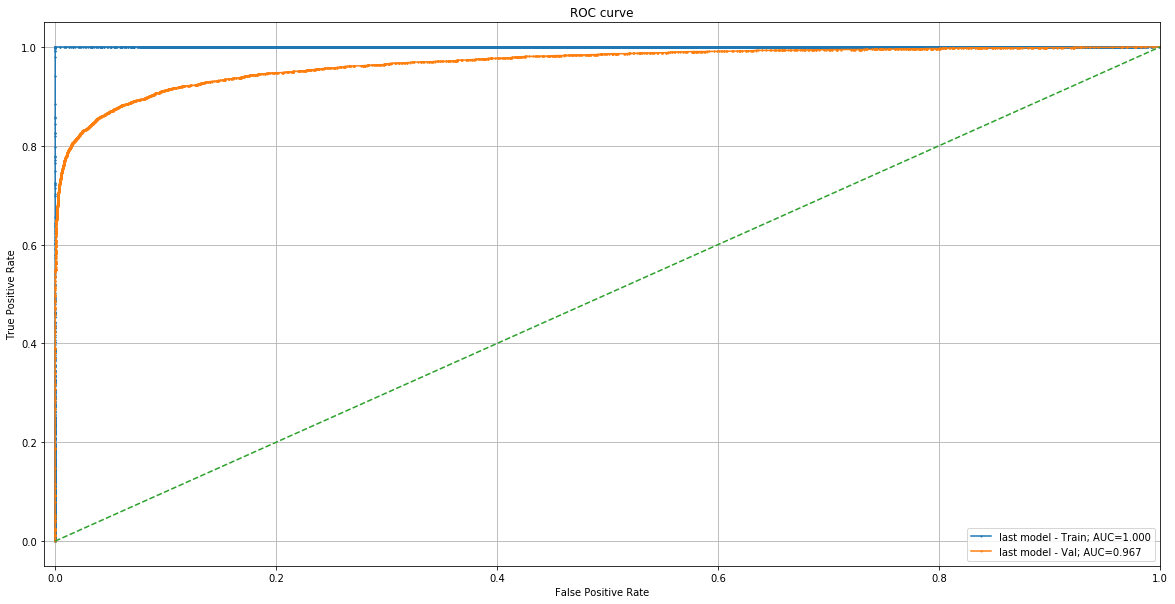

In [292]:
# See Train and valid performance

plot_roc(
    [y_tr, y_vl],
    [y_pred_train,y_pred_valid],
    ['last model - Train', 'last model - Val'])


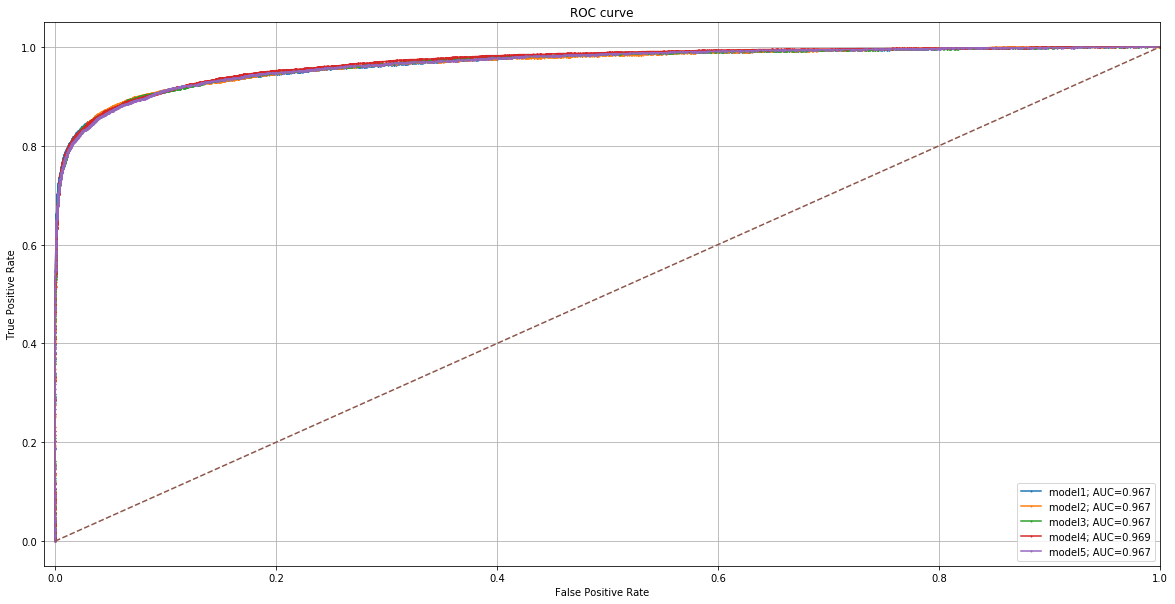

In [293]:
plot_roc(
    y_vl_list,
    y_pred_val_list,
    labels,
)


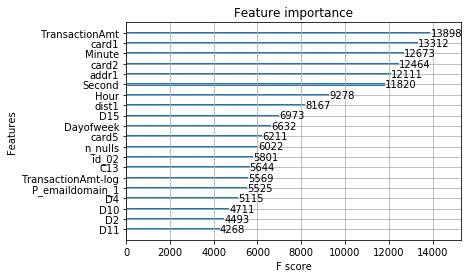

In [294]:
xgb.plot_importance(m,max_num_features=20,height=0.2)

In [0]:
test_preds = list()
for m in models_cv:
    test_preds.append(m.predict_proba(test_data)[:,1])
test_preds = np(test_preds).mean(axis=0)

## Conclusions


In [0]:
'''
a)  the best model is the Baseline model ( 97.5 % vs 96.6% and 96.7%) which 

'''


In [0]:
'''
This data set is quite challenging due to:

a) The data has been anonimized and it requires a lot of domain experise to extract all the potential information from this dataset.
b) There is not date information in the dataset so I can't use external data
c) there is a big quantity of missing values, which could be compensate using b)


'''


In [0]:
'''
How to improve the model:

a) Further FEA: I would like to create some aggregation between the cards variables + transaction amount. Card1, as per the importance plot, is heavily linked
with the fraud and I feel I could have extracted more info from it.

b) Hyper parameter tunning: I would like to have done some extra hyper parameter tunning 

c) Try another architechture: comparing the feature importances for two different models (RandomForest vs XGBoost for instance) 
by comparing how important the variables are can help to see if a model grasps the predictive power of a variable.

d) Deep Learning: Although is not as succesfull as XGB for tablular data, Deep NN + Entity Embeddings can be more powerful.

'''

## Annex

In [0]:
train_df=pd.read_csv(path_to_drive/'train_transaction.csv', low_memory=True);
reduce_mem_usage(train_df);
train_df.head()

Text(0, 0.5, 'Probability')

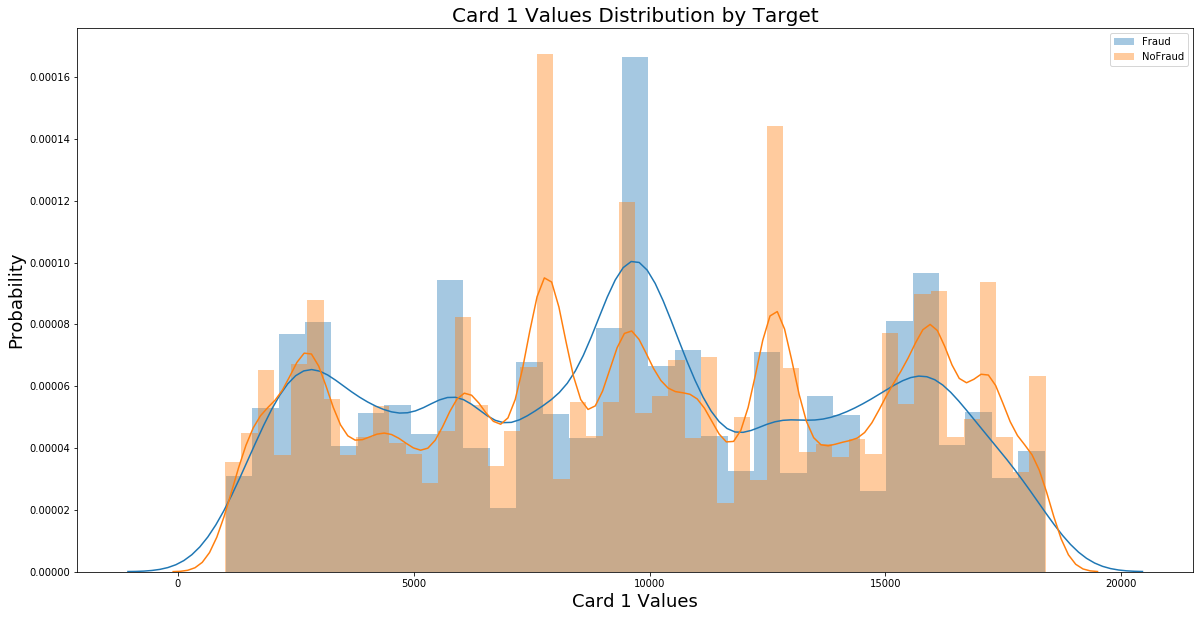

In [300]:
plt.figure(figsize=(20,10))


plot_1 = sns.distplot(train_df[train_df['isFraud'] == 1]['card1'], label='Fraud')
plot_1 = sns.distplot(train_df[train_df['isFraud'] == 0]['card1'], label='NoFraud')
plot_1.legend()
plot_1.set_title("Card 1 Values Distribution by Target", fontsize=20)
plot_1.set_xlabel("Card 1 Values", fontsize=18)
plot_1.set_ylabel("Probability", fontsize=18)
